In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)

from foods.meals import molly_meals, paps_meals, fabian_meals, test_meals
from foods.dashboard import read_raw, find_food, calc_nuts, make_dashboard, make_nutrient_graphs

%load_ext autoreload
%autoreload 2

In [2]:
def str_to_numeric(df):
    cols = ['calories', 'fat', 'carbs', 'sugar', 'fiber', 'protein']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def str_to_lower(df):
    cols = df.columns[df.dtypes.eq('object')]
    df[cols] = df[cols].applymap(str.lower)
    return df

columns = {
    'Name': 'ingredient',
    'Category': 'category',
    'Matrix unit': 'units',
    'Energy, kilocalories (kcal)': 'calories',
    'Fat, total (g)': 'fat',
    'Carbohydrates, available (g)': 'carbs',
    'Protein (g)': 'protein',
    'Sugars (g)': 'sugar',
    'Dietary fibres (g)': 'fiber',
}

path = './data/Swiss-food-composition-database-V6.1.xlsx'
    
foods = (
    pd.read_excel(path, skiprows=2, usecols=columns)
    .rename(columns=columns)
    .pipe(str_to_numeric)
    .pipe(str_to_lower)
)

print(foods.shape)
foods.head()

(1018, 9)


,ingredient,category,units,calories,fat,carbs,sugar,fiber,protein
0,agar agar,various/gelling and binding agents,per 100g edible portion,160,0.2,0.0,NaN,74.1,2.4
1,agave syrup,sweets/sugar and sweeteners,per 100g edible portion,293,0.0,73.1,NaN,0.0,0.2
2,almond,"nuts, seeds and oleaginous fruit",per 100g edible portion,593,49.9,4.0,3.9,13.0,25.5
3,"almond, dry roasted, salted","savoury snacks/salted nuts, seeds and kernels",per 100g edible portion,634,52.1,10.3,4.9,10.9,25.4
4,"almond, roasted, salted","savoury snacks/salted nuts, seeds and kernels",per 100g edible portion,649,55.2,7.2,4.6,10.5,25.6


In [43]:
def find_item(regex, cat=False):
    if not cat:
        subset = foods.ingredient.str.contains(regex)
    else:
        subset = foods.category.str.contains(regex)
    return foods[subset]
        

find_item('nut')

,ingredient,category,units,calories,fat,carbs,sugar,fiber,protein
113,brazil nut,"nuts, seeds and oleaginous fruit",per 100g edible portion,693,66.5,3.2,2.3,7.0,17.0
121,bread with walnuts,"bread, flakes and breakfast cereals/bread and bread products",per 100g edible portion,339,18.5,30.8,1.8,5.8,9.4
164,cashew nut,"nuts, seeds and oleaginous fruit",per 100g edible portion,606,45.2,26.6,5.9,3.6,21.5
185,"chestnut, raw","nuts, seeds and oleaginous fruit",per 100g edible portion,200,1.5,42.4,5.0,1.4,3.4
224,coconut,"nuts, seeds and oleaginous fruit",per 100g edible portion,479,42.0,16.0,5.0,9.5,4.6
225,"coconut, dried (coco flakes)","nuts, seeds and oleaginous fruit",per 100g edible portion,667,63.3,6.4,6.4,20.0,8.1
226,coconut fat,fats and oils/fats,per 100g edible portion,894,99.0,0.0,0.0,0.0,0.8
271,"croissant filled with nuts, puff pastry",sweets/other sweet pastries,per 100g edible portion,417,26.9,35.6,16.1,2.7,6.8
272,"croissant filled with nuts, yeast dough",sweets/other sweet pastries,per 100g edible portion,316,12.6,41.5,18.5,2.8,7.7
342,"flour omelette with nutella, prepared",prepared dishes/other sweet dishes,per 100g edible portion,258,12.4,29.0,14.4,1.4,7.1


In [47]:
meals = {

    'Lunch': {
        'coconut fat': 0.2,
        'scrambled eggs, prepared': 2.4,
        'mushroom, stewed (without addition of fat and salt)': 0.5,
        'spinach, steamed (without addition of salt)': 0.5,
        
        'iceberg lettuce, raw': 0.5,
        'avocado, fresh': 1.6,
        'bell pepper, red, raw': 0.5,
        'seeds, kernels, nuts (average), unsalted': 0.2,
        'olive oil': 0.2,
        'vinegar': 0.1,
    },
    
    'Snack': {
        'coconut fat': 0.2,
        'cocoa powder': 0.05,
        'coffee, black, no sugar added': 1,
        'brazil nut': 0.5
    },
    
    'Supper': {
        'iceberg lettuce, raw': 0.3,
        'avocado, fresh': 0.8,
        'bell pepper, red, raw': 0.3,
        
        'chicken, leg with skin, roasted (without addition of fat and salt)': 2.5,
        
        'coconut fat': 0.2,
        'kohlrabi, steamed (without addition of salt)': 0.4,
        'carrot, steamed (without addition of salt)': 0.2,
        'cauliflower, steamed (without addition of salt)': 0.4,
        'vegetables (average), raw': 1
    }
}

In [53]:
def get_meal_data(meal):

    # Grams data
    data = (foods[foods.ingredient.isin(meal)].copy()
            .set_index('ingredient')
            .drop(['units', 'category', 'calories', 'sugar'], axis=1))
    portion = data.index.map(meal)
    grams = data.multiply(portion, axis=0)
    grams = grams[['fat', 'protein', 'fiber', 'carbs']]
        
    # Calories data
    calories = grams.copy()
    calories['fat'] = calories.fat * 9
    calories['carbs'] = calories.carbs * 4
    calories['protein'] = calories.protein * 4
    calories['fiber'] = calories.fiber * 2
    
    return {'grams': grams, 'cals': calories}

# Calc grams and calories for all meals
meal_data = {meal: get_meal_data(meals[meal]) for meal in meals}

# Add gram and calorie totals
totals = {}
for measure in ['cals', 'grams']:
    pieces = []
    for meal in meal_data.keys():
        pieces.append(meal_data[meal][measure])
    total = pd.concat(pieces).groupby(level=0).sum()
    totals[measure] = total

meal_data['Total'] = totals

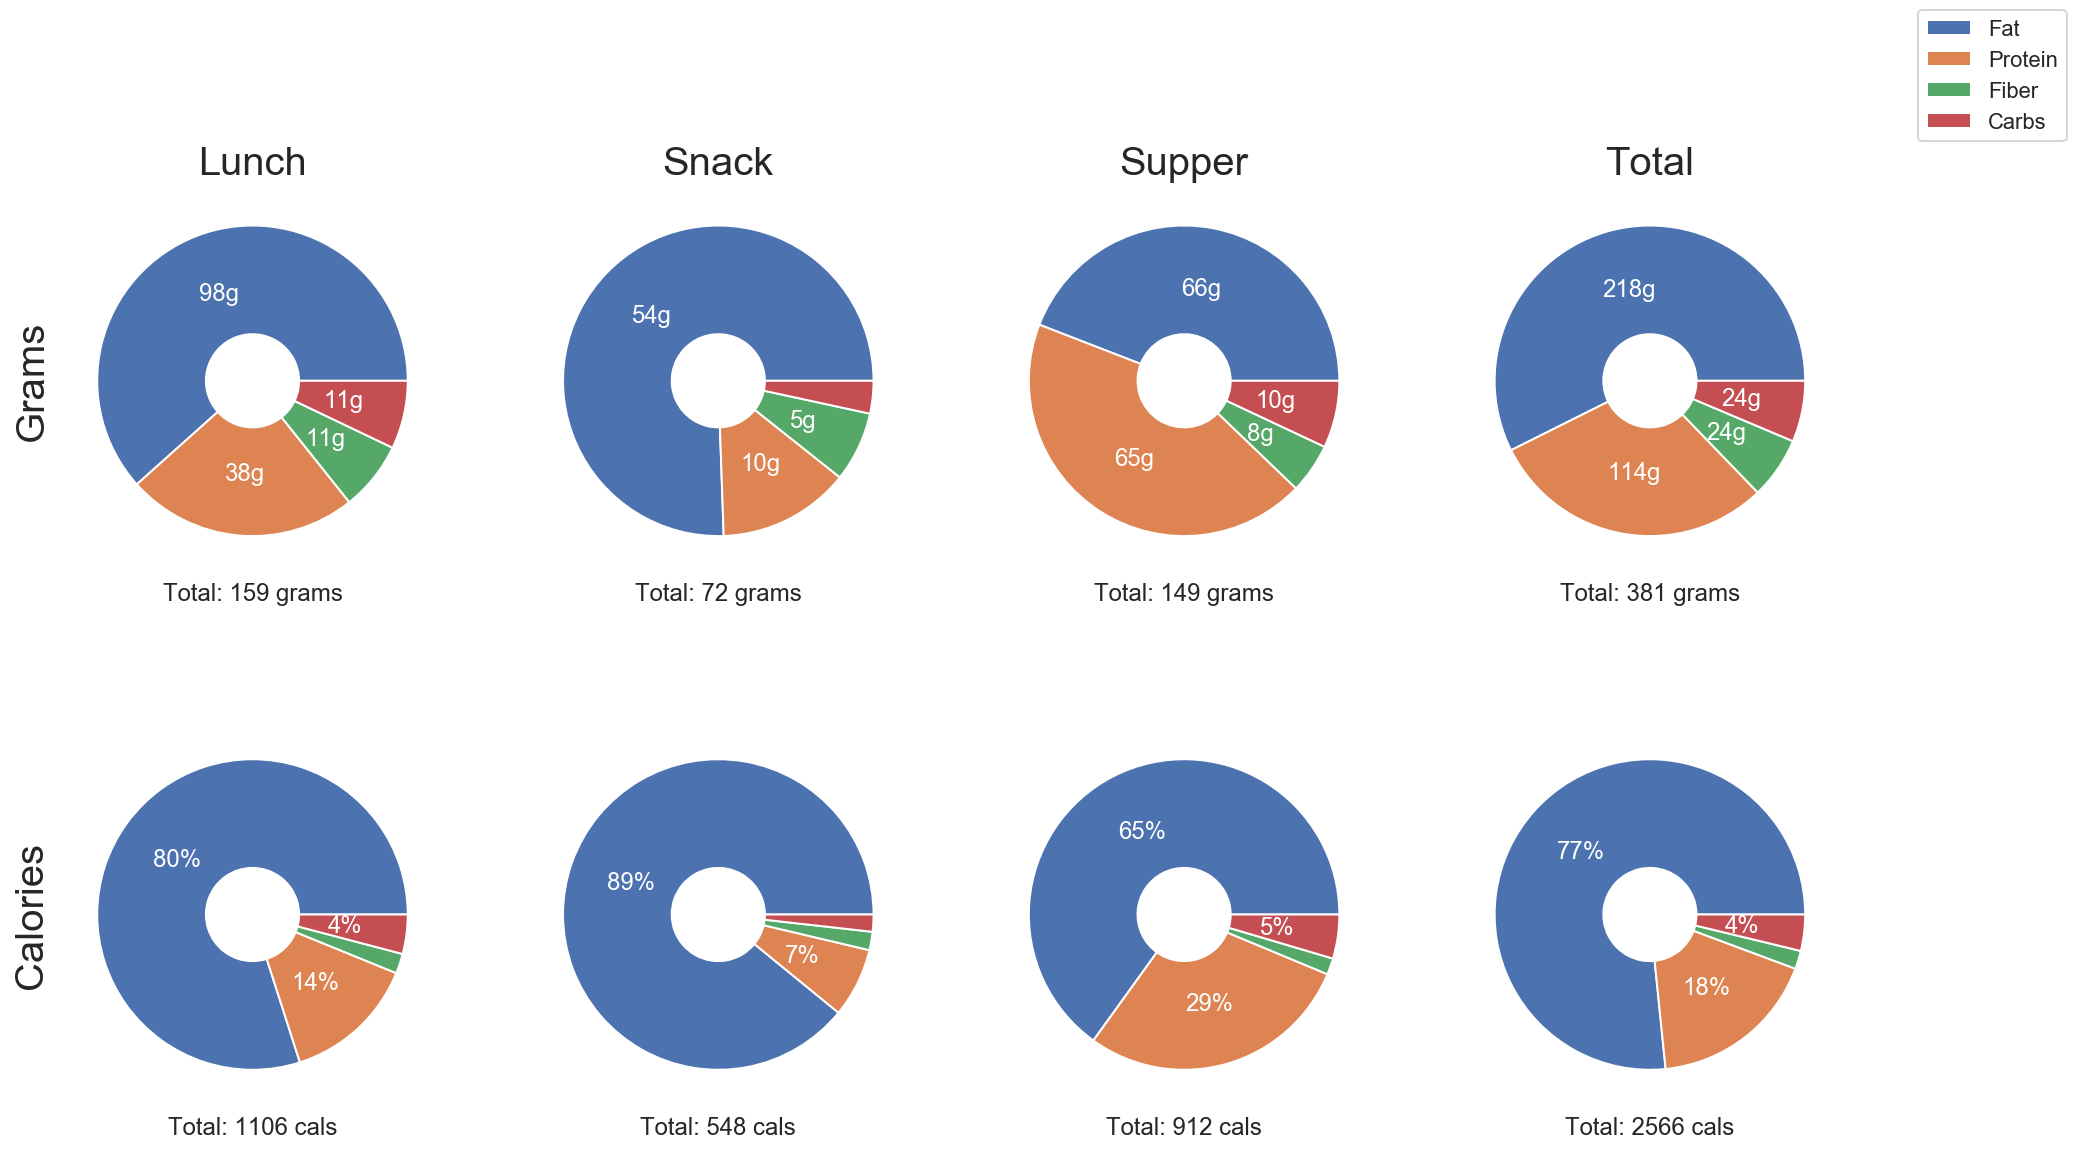

In [60]:
axsize = 20

def make_autopct(values):
    def pct_labels(pct):
        if measure == 'cals':
            out =  f'{pct:.0f}%' if pct > 3 else ''
        else:
            grams = pct * total / 100
            out = f'{grams:.0f}g' if grams > 3 else ''
        return out
    return pct_labels


num_meals = len(meal_data)
fig, ax = plt.subplots(2, num_meals)

ax[0, 0].set_ylabel('Grams', fontsize=axsize)
ax[1, 0].set_ylabel('Calories', fontsize=axsize)

for col, meal in enumerate(meal_data):
    for row, measure in enumerate(['grams', 'cals']):
        
        data = meal_data[meal][measure].sum()
        total = data.sum()
        
        ax[row, col].pie(data, autopct=make_autopct(data),
                         wedgeprops=dict(width=0.7),
                         textprops=dict(color='white')
                        )
        ax[row, col].set_xlabel(f'Total: {total:.0f} {measure}')
        ax[0, col].set_title(meal, fontsize=axsize)
        
fig.legend(['Fat', 'Protein', 'Fiber', 'Carbs']);